Dataset shape: (284807, 31)
Fraud cases: 492
Fraud ratio: 0.00173
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best CV ROC-AUC: 0.985442
Best Params: {'colsample_bytree': np.float64(0.9598528437324805), 'gamma': np.float64(0.18033450352296262), 'learning_rate': np.float64(0.09496870933552545), 'max_depth': 8, 'n_estimators': 608, 'reg_alpha': np.float64(0.9699098521619943), 'reg_lambda': np.float64(1.6648852816008435), 'subsample': np.float64(0.7637017332034828)}

Chosen decision threshold: 0.5562

==== Test Metrics ====
Accuracy     : 0.999526
Precision    : 0.873684
Recall       : 0.846939
F1 Score     : 0.860104
ROC AUC      : 0.972478

Classification Report:
               precision    recall  f1-score   support

           0   0.999736  0.999789  0.999763     56864
           1   0.873684  0.846939  0.860104        98

    accuracy                       0.999526     56962
   macro avg   0.936710  0.923364  0.929933     56962
weighted avg   0.999519  0.999526  0.9

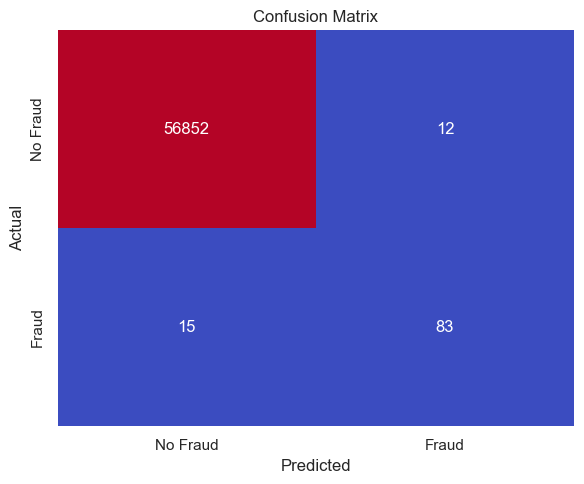

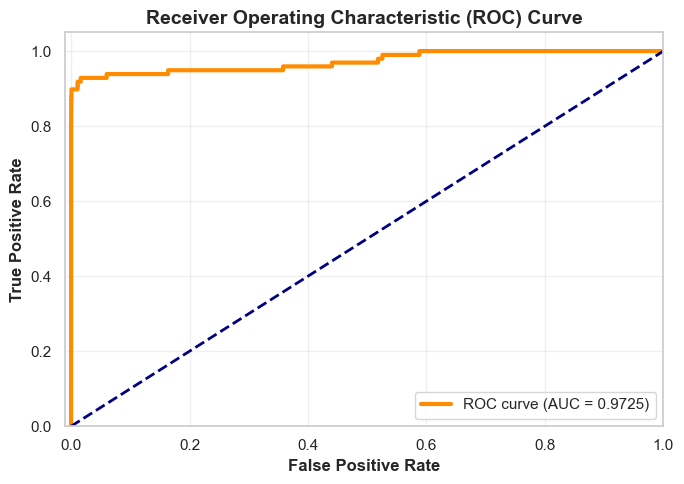

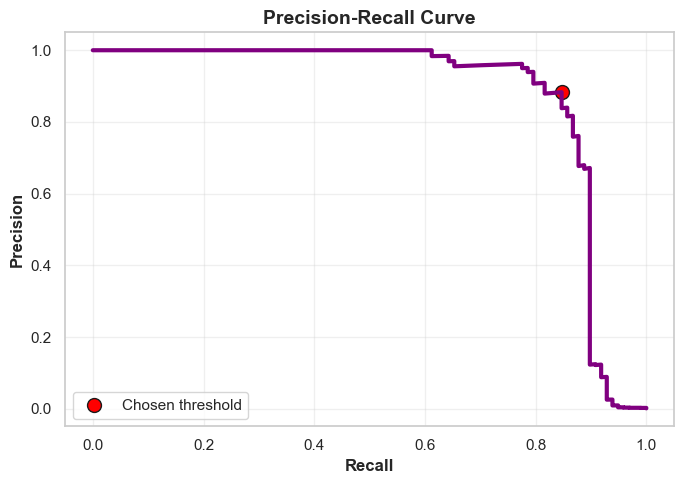

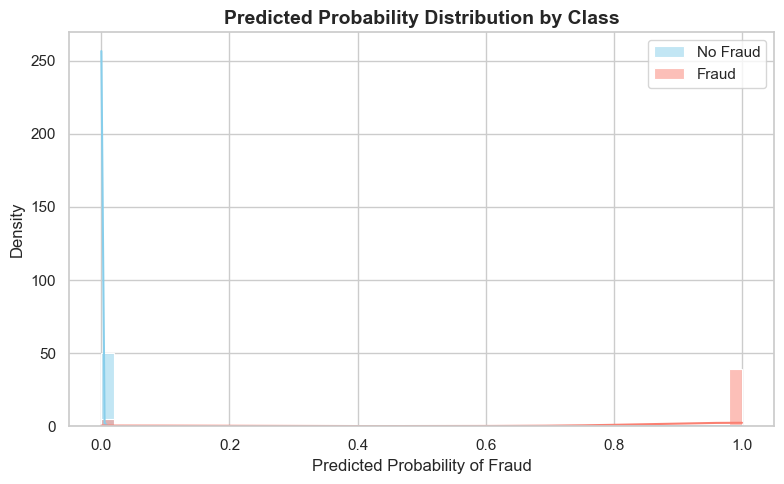

C:\Users\IT SOLUTION\AppData\Local\Temp\ipykernel_6420\2420261747.py:191: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=features, palette="viridis")


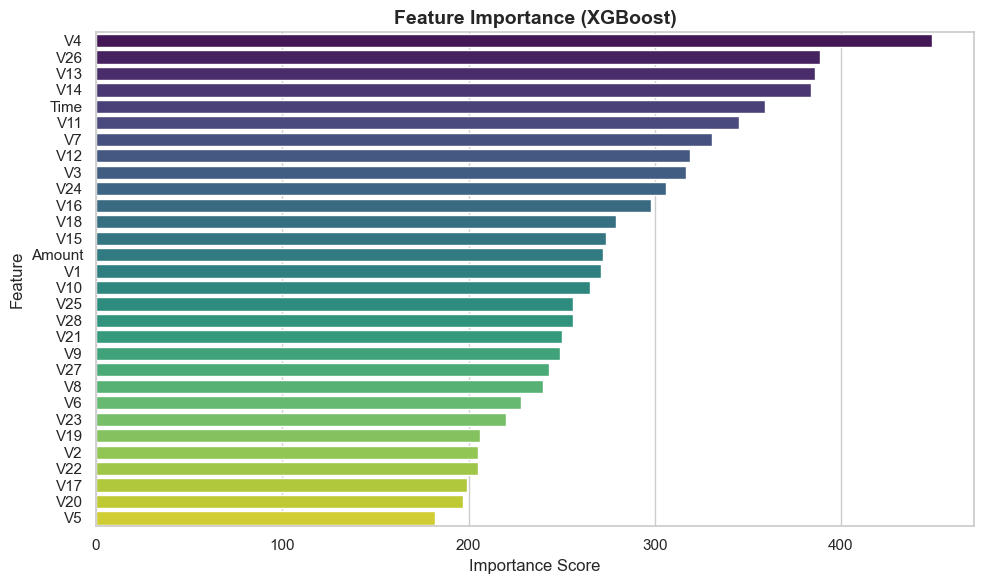

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve,
    ConfusionMatrixDisplay
)

from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# -----------------
# 1. Load Dataset
# -----------------
df = pd.read_csv("creditcard.csv")  
print("Dataset shape:", df.shape)
print("Fraud cases:", int(df['Class'].sum()))
print("Fraud ratio: {:.5f}".format(df['Class'].mean()))

# -----------------
# 2. Preprocessing
# -----------------
X = df.drop(columns=["Class"])
y = df["Class"].astype(int)

# Scale only 'Time' and 'Amount' columns
scaler = StandardScaler()
for col in ("Time", "Amount"):
    if col in X.columns:
        X[col] = scaler.fit_transform(X[[col]])

# -----------------
# 3. Train-Test Split 
# -----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------
# 4. Model and Hyperparameter Search (ROC-AUC)
# -----------------
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / max(pos, 1)

base_model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    gamma=0.0,
    tree_method="hist",
    eval_metric="auc",
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

param_distributions = {
    "n_estimators": randint(300, 800),
    "max_depth": randint(3, 9),
    "learning_rate": uniform(0.01, 0.12),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "reg_lambda": uniform(0.0, 2.0),
    "reg_alpha": uniform(0.0, 1.0),
    "gamma": uniform(0.0, 0.3),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("\nBest CV ROC-AUC: {:.6f}".format(search.best_score_))
print("Best Params:", search.best_params_)

best_model = search.best_estimator_

# -----------------
# 5. Predict Probabilities on Test
# -----------------
y_proba = best_model.predict_proba(X_test)[:, 1]

# -----------------
# 6. Threshold Tuning 
# -----------------
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_proba)
f1s = np.where((precisions + recalls) > 0, 2 * (precisions * recalls) / (precisions + recalls), 0)
best_idx = np.argmax(f1s)
best_threshold = thresholds_pr[max(best_idx - 1, 0)] if best_idx < len(thresholds_pr) else 0.5
print("\nChosen decision threshold: {:.4f}".format(best_threshold))

y_pred = (y_proba >= best_threshold).astype(int)

# -----------------
# 7. Evaluation
# -----------------
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc_score = roc_auc_score(y_test, y_proba)

print("\n==== Test Metrics ====")
print(f"Accuracy     : {acc:.6f}")
print(f"Precision    : {prec:.6f}")
print(f"Recall       : {rec:.6f}")
print(f"F1 Score     : {f1:.6f}")
print(f"ROC AUC      : {auc_score:.6f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=6))


# 8. Visualizations

sns.set(style="whitegrid")

# 8.1 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False,
            xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 8.2 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color="darkorange", lw=3, label=f"ROC curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12, fontweight='bold')
plt.ylabel("True Positive Rate", fontsize=12, fontweight='bold')
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 8.3 Precision-Recall Curve with best threshold
plt.figure(figsize=(7,5))
plt.plot(recalls, precisions, color="purple", lw=3)
plt.scatter(recalls[best_idx], precisions[best_idx], color="red", s=100, label="Chosen threshold", edgecolors='k')
plt.xlabel("Recall", fontsize=12, fontweight='bold')
plt.ylabel("Precision", fontsize=12, fontweight='bold')
plt.title("Precision-Recall Curve", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 8.4 Distribution of Predicted Probabilities by Class
plt.figure(figsize=(8,5))
sns.histplot(y_proba[y_test == 0], bins=50, color="skyblue", label="No Fraud", stat='density', kde=True)
sns.histplot(y_proba[y_test == 1], bins=50, color="salmon", label="Fraud", stat='density', kde=True)
plt.title("Predicted Probability Distribution by Class", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Probability of Fraud")
plt.ylabel("Density")
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# 8.5 Feature Importance Plot (XGBoost)
plt.figure(figsize=(10,6))
xgb_importance = best_model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(xgb_importance.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*sorted_importance)
sns.barplot(x=scores, y=features, palette="viridis")
plt.title("Feature Importance (XGBoost)", fontsize=14, fontweight='bold')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
